# H2O Uplift Distributed Random Forest 

### Author: Veronika Maurerova veronika.maurerova@h2o.ai

## Modeling Uplift 

Distributed Uplift Random Forest (Uplift DRF) is a classification tool for modeling uplift - the incremental impact of a treatment. This tool is very useful for example in marketing or in medicine. This machine learning approach is inspired by the A/B testing method. 

To model uplift, the analyst needs to collect data specifically - before the experiment, the objects are divided usually into two groups: 

- **treatment group**: receive some kind of treatment (for example customer get some type of discount) 
- **control group**: is separated from the treatment (customers in this group get no discount). 

Then the data are prepared and an analyst can gather information about the response - for example, whether customers bought a product, patients recovered from the disease, or similar. 

## Uplift approaches 

There are several approaches to model uplift: 

- Meta-learner algorithms
- Instrumental variables algorithms
- Neural-networks-based algorithms
- Tree-based algorithms 



## Tree Based Uplift Algorithm

Tree-based algorithm means in every tree, it takes information about treatment/control group assignment and information about response directly into a decision about splitting a node. The uplift score is the criterion to make a decision similar to the Gini coefficient in the standard decision tree. 

**Uplift metric to decide best split**

The goal is to maximize the differences between the class distributions in the treatment and control sets, so the splitting criteria are based on distribution divergences. The distribution divergence is calculated based on the ``uplift_metric`` parameter. In H2O-3, three ``uplift_metric`` types are supported:

- **Kullback-Leibler divergence** (``uplift_metric="KL"``) - uses logarithms to calculate divergence, asymmetric, widely used, tends to infinity values (if treatment or control group distributions contain zero values). 

$ KL(P, Q) = \sum_{i=0}^{N} p_i \log{\frac{p_i}{q_i}}$

- **Squared Euclidean distance** (``uplift_metric="euclidean"``) - symmetric and stable distribution, does not tend to infinity values. 

$ E(P, Q) = \sum_{i=0}^{N} (p_i-q_i)^2$


- **Chi-squared divergence** (``uplift_metric="chi_squared"``) - Euclidean divergence normalized by control group distribution. Asymmetric and also tends to infinity values (if control group distribution contains zero values). 

$X^2(P, Q) = \sum_{i=0}^{N} \frac{(p_i-q_i)^2}{q_i}$

where:

- $P$ is treatment group distribution

- $Q$ is control group distribution

In a tree node the result value for a split is sum: $metric(P, Q) + metric(1-P, 1-Q)$. 

For the split gain value, the result within the node is normalized using a Gini coefficient (Eclidean or ChiSquared) or entropy (KL) for each distribution before and after the split.


**Uplift score in each leaf is calculated as:**

- $TP = (TY1 + 1) / (T + 2)$
- $CP = (CY1 + 1) / (C + 2)$
- $uplift\_score = TP - CP $

where:
- $T$ how many observations in a leaf are from the treatment group (how many data rows in a leaf have ``treatment_column`` label == 1) 
- $C$ how many observations in a leaf are from the control group (how many data rows in the leaf have ``treatment_column`` label == 0)
- $TY1$ how many observations in a leaf are from the treatment group and respond to the offer (how many data rows in the leaf have ``treatment_column`` label == 1 and ``response_column`` label == 1)
- $CY1$ how many observations in a leaf are from the control group and respond to the offer (how many data rows in the leaf have ``treatment_column`` label == 0 and ``response_column`` label == 1)

**Note**: A higher uplift score means more observations from treatment group respond to the offer than from control group. Which means offered treatment has positive effect. The uplift score can be negative, if more observations from control group respond to the offer without treatment.

<br>
<br>

![Difference between SDT and Uplift DT](https://blog.h2o.ai/wp-content/uploads/2022/01/tree.png)




## H2O Implementation (Major release 3.36)

The H2O-3 implementation of Uplift DRF is based on DRF because the principle of training is similar to DRF. It is tree based uplift algorithm. Uplift DRF generates a forest of classification uplift trees, rather than a single classification tree. Each of these trees is a weak learner built on a subset of rows and columns. More trees will reduce the variance. Classification takes the average prediction over all of their trees to make a final prediction. 

Currently, in H2O-3 only binomial trees are supported, as well as the uplift curve metric and Area Under Uplift curve (AUUC) metric, normalized AUUC, and the Qini value. We are working on adding also regression trees and more metrics, for example, Qini coefficient, and more. 

## Start H2O-3

In [1]:
import sys
sys.path.append("../build/main")

import h2o
from h2o.estimators.uplift_random_forest import H2OUpliftRandomForestEstimator

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style

import pandas as pd

versionFromGradle='3.36.1',projectVersion='3.36.1.99999',branch='rel-zumbo',lastCommitHash='673f3fa5fc3c3e8f7e8b797db61e6488fe56f7e1',gitDescribe='jenkins-3.36.1.3-13-g673f3fa5fc-dirty',compiledOn='2022-07-26 01:46:40',compiledBy='adam'


In [2]:
h2o.init(strict_version_check=False, max_mem_size=16)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_311"; Java(TM) SE Runtime Environment (build 1.8.0_311-b11); Java HotSpot(TM) 64-Bit Server VM (build 25.311-b11, mixed mode)
  Starting server from /Users/adam/h2o-3/build/h2o.jar
  Ice root: /var/folders/2z/9gdhqbns0djdj9crb242sgc00000gn/T/tmpklts654p
  JVM stdout: /var/folders/2z/9gdhqbns0djdj9crb242sgc00000gn/T/tmpklts654p/h2o_adam_started_from_python.out
  JVM stderr: /var/folders/2z/9gdhqbns0djdj9crb242sgc00000gn/T/tmpklts654p/h2o_adam_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_adam_iijzlz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,14.22 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


## Load data

To demonstrate how Uplift DRF works, Criteo dataset is used. 

**Source:**

Diemert Eustache, Betlei Artem} and Renaudin, Christophe and Massih-Reza, Amini, "A Large Scale Benchmark for Uplift Modeling", ACM, Proceedings of the AdKDD and TargetAd Workshop, KDD, London,United Kingdom, August, 20, 2018, https://ailab.criteo.com/criteo-uplift-prediction-dataset/.



**Description:**

- The dataset was created by The Criteo AI Lab
- Consists of 13M rows, each one representing a user with 12 features, a treatment indicator and 2 binary labels (visits and conversions).
- Positive labels mean the user visited/converted on the advertiser website during the test period (2 weeks).
- The global treatment ratio is 84.6%.

**Detailed description of the columns:**

- **f0, f1, f2, f3, f4, f5, f6, f7, f8, f9, f10, f11**: feature values (dense, float)
- **treatment**: treatment group (1 = treated, 0 = control)
- **conversion**: whether a conversion occured for this user (binary, label)
- **visit**: whether a visit occured for this user (binary, label)
- **exposure**: treatment effect, whether the user has been effectively exposed (binary)

In [3]:
control_name = "control"
treatment_column = "treatment"
response_column = "visit"
feature_cols = ["f"+str(x) for x in range(0,12)]

df = pd.read_csv("../../bigdata/laptop/criteo-uplift-v2.1.csv")
df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,12.616365,10.059654,8.976429,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
1,12.616365,10.059654,9.002689,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
2,12.616365,10.059654,8.964775,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
3,12.616365,10.059654,9.002801,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
4,12.616365,10.059654,9.037999,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0


## Prepare data

Inspiration from: https://www.kaggle.com/code/hughhuyton/criteo-uplift-modelling/notebook

To modeling uplift the treatment and control group data have to have similar distribution. In real world usually the control group is smaller than the treatment group. It is also a case of Crieteo dataset and we have to rebalanced the data to have a similar size.

In [4]:
print('Total number of samples: {}'.format(len(df)))
print('The dataset is largely imbalanced: ')
print(df['treatment'].value_counts(normalize = True))
print('Percentage of users that visit: {}%'.format(100*round(df['visit'].mean(),4)))
print('Percentage of users that convert: {}%'.format(100*round(df['conversion'].mean(),4)))
print('Percentage of visitors that convert: {}%'.format(100*round(df[df["visit"]==1]["conversion"].mean(),4)))

Total number of samples: 13979592
The dataset is largely imbalanced: 
1    0.85
0    0.15
Name: treatment, dtype: float64
Percentage of users that visit: 4.7%
Percentage of users that convert: 0.29%
Percentage of visitors that convert: 6.21%


Class 0: 2096937
Class 1: 11882655
Proportion: 6 : 1


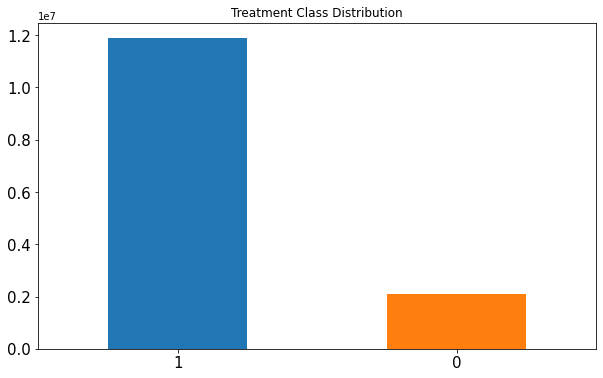

In [5]:
# Print proportion of a binary column
# https://www.kaggle.com/code/hughhuyton/criteo-uplift-modelling/notebook
def print_proportion(df, column):
    fig = plt.figure(figsize = (10,6))
    target_count = df[column].value_counts()
    print('Class 0:', target_count[0])
    print('Class 1:', target_count[1])
    print('Proportion:', int(round(target_count[1] / target_count[0])), ': 1')
    target_count.plot(kind='bar', title='Treatment Class Distribution', color=['#2077B4', '#FF7F0E'], fontsize = 15)
    plt.xticks(rotation=0) 
    
print_proportion(df, treatment_column)

In [6]:
from sklearn.model_selection import train_test_split
train_df, test_df  = train_test_split(df, test_size=0.2, random_state=42, stratify=df['treatment'])
print(train_df.shape)
print(test_df.shape)

(11183673, 16)
(2795919, 16)


In [7]:
del(df)

Class 0: 1677550
Class 1: 9506123
Proportion: 6 : 1


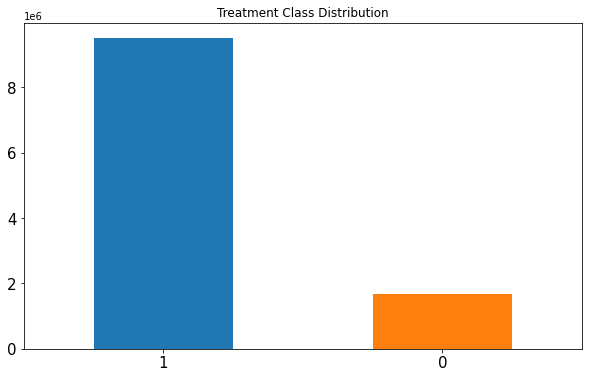

In [8]:
print_proportion(train_df, treatment_column)

In [9]:
# Random Undersampling (finding the majority class and undersampling it)
# https://www.kaggle.com/code/hughhuyton/criteo-uplift-modelling/notebook
def random_under(df, feature):
    
    target = df[feature].value_counts()
    
    if target.values[0]<target.values[1]:
        under = target.index.values[1]
    
    else: 
        under = target.index.values[0]
        
    df_0 = df[df[feature] != under]
    df_1 = df[df[feature] == under]
    
    df_treatment_under = df_1.sample(len(df_0))
    df_1 = pd.concat([df_treatment_under, df_0], axis=0)
    
    return df_1

In [10]:
train_df = random_under(train_df, treatment_column)

Class 0: 1677550
Class 1: 1677550
Proportion: 1 : 1


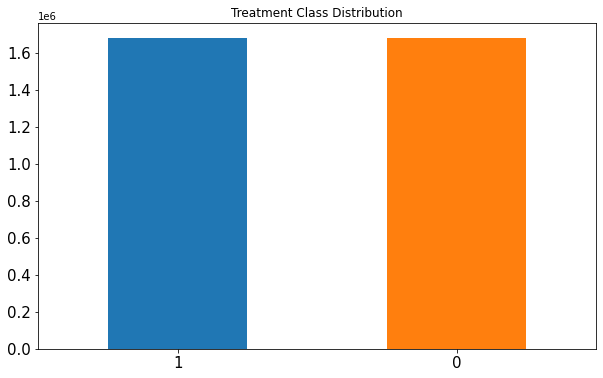

In [11]:
print_proportion(train_df, treatment_column)

In [12]:
# method to transfor data for LGWUM method, will be explained later
def target_class_lgwum(df, treatment, target, column_name):
    
    #CN:
    df[column_name] = 0 
    #CR:
    df.loc[(df[treatment] == 0) & (df[target] != 0), column_name] = 1 
    #TN:
    df.loc[(df[treatment] != 0) & (df[target] == 0), column_name] = 2 
    #TR:
    df.loc[(df[treatment] != 0) & (df[target] != 0), column_name] = 3 
    return df

response_column_lgwum = "lqwum_response"
train_df = target_class_lgwum(train_df, treatment_column, response_column, response_column_lgwum)
test_df = target_class_lgwum(test_df, treatment_column, response_column, response_column_lgwum)

## Import data to H2O

In [13]:
h2o_train_df = h2o.H2OFrame(train_df)
del(train_df)

h2o_train_df[treatment_column] = h2o_train_df[treatment_column].asfactor()
h2o_train_df[response_column] = h2o_train_df[response_column].asfactor()
h2o_train_df[response_column_lgwum] = h2o_train_df[response_column_lgwum].asfactor()

h2o_test_df = h2o.H2OFrame(test_df)

h2o_test_df[treatment_column] = h2o_test_df[treatment_column].asfactor()
h2o_test_df[response_column] = h2o_test_df[response_column].asfactor()
h2o_test_df[response_column_lgwum] = h2o_test_df[response_column_lgwum].asfactor()
del(test_df)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


## Train H2O UpliftDRF model

In [14]:
ntree = 20
max_depth = 15
metric="Euclidean"

h2o_uplift_model = H2OUpliftRandomForestEstimator(
                    ntrees=ntree,
                    max_depth=max_depth,
                    min_rows=30,
                    nbins=1000,
                    sample_rate=0.80,
                    score_each_iteration=True,
                    treatment_column=treatment_column,
                    uplift_metric=metric,
                    auuc_nbins=1000,
                    auuc_type="gain",
                    seed=42)

h2o_uplift_model.train(y=response_column, x=feature_cols, training_frame=h2o_train_df)
h2o_uplift_model

upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Model Details
H2OUpliftRandomForestEstimator :  Uplift Distributed Random Forest
Model Key:  UpliftDRF_model_python_1658935440132_1


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,20.0,40.0,168813.0,15.0,15.0,15.0,289.0,420.0,332.8




ModelMetricsBinomialUplift: upliftdrf
** Reported on train data. **

AUUC: 29169.922968109066
AUUC normalized: 0.8291149726595725

AUUC table (number of bins: 976): All types of AUUC value


,uplift_type,qini,lift,gain
0,AUUC value,14736.247441,0.027808,29169.922968
1,AUUC normalized,0.837715,0.027808,0.829115
2,AUUC random value,8805.991068,0.005249,17611.982136



Qini value: 5930.256373120586

AECU values table: All types of AECU value


,uplift_type,qini,lift,gain
0,AECU value,5930.256373,0.022559,11557.940832



Scoring History: 


,,timestamp,duration,number_of_trees,training_auuc_nbins,training_auuc,training_auuc_normalized,training_qini_value
0,,2022-07-27 17:29:08,0.080 sec,0.0,0,NaN,NaN,NaN
1,,2022-07-27 17:29:13,4.490 sec,1.0,17,29173.472499,0.829216,43.134923
2,,2022-07-27 17:29:28,19.408 sec,2.0,37,26175.248236,0.743995,543.787973
3,,2022-07-27 17:29:50,41.424 sec,3.0,65,24834.896604,0.705898,1189.586996
4,,2022-07-27 17:30:15,1 min 6.550 sec,4.0,105,24668.993241,0.701182,1993.933129
5,,2022-07-27 17:30:33,1 min 25.226 sec,5.0,151,24978.681660,0.709985,2735.106363
6,,2022-07-27 17:30:56,1 min 47.655 sec,6.0,213,25507.086140,0.725004,3370.884460
7,,2022-07-27 17:31:29,2 min 20.452 sec,7.0,284,26091.307166,0.741610,3906.033948
8,,2022-07-27 17:32:00,2 min 51.737 sec,8.0,357,26636.653904,0.757110,4340.058619
9,,2022-07-27 17:32:24,3 min 15.845 sec,9.0,455,27007.925202,0.767663,4630.005209



See the whole table with table.as_data_frame()


## Predict and plot Uplift Score

In [15]:
# Plot uplift score
# source https://www.kaggle.com/code/hughhuyton/criteo-uplift-modelling/notebook
def plot_uplift_score(uplift_score):
    plt.figure(figsize = (10,6))
    plt.xlim(-.05, .1)
    plt.hist(uplift_score, bins=1000, color=['#2077B4'])
    plt.xlabel('Uplift score')
    plt.ylabel('Number of observations in validation set')

In [16]:
h2o_uplift_pred = h2o_uplift_model.predict(h2o_test_df)
h2o_uplift_pred

upliftdrf prediction progress: |█████████████████████████████████████████████████| (done) 100%


uplift_predict,p_y1_ct1,p_y1_ct0
0.000478117,0.0014641,0.000985981
0.000478117,0.0014641,0.000985981
0.000478117,0.0014641,0.000985981
0.0420628,0.09183,0.0497673
0.000478117,0.0014641,0.000985981
0.000478117,0.0014641,0.000985981
0.000478117,0.0014641,0.000985981
0.00117217,0.0342161,0.033044
0.000478117,0.0014641,0.000985981
0.000478117,0.0014641,0.000985981


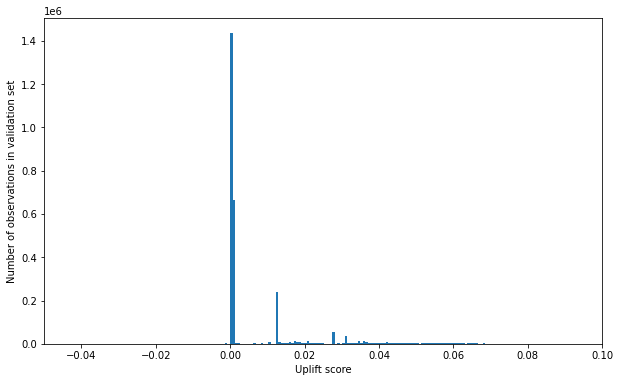

In [17]:
plot_uplift_score(h2o_uplift_pred['uplift_predict'].as_data_frame().uplift_predict)

## Evaluate the model

In [18]:
perf_h2o = h2o_uplift_model.model_performance(h2o_test_df)



### Area Under Uplift Curve (AUUC) calculation

To calculate AUUC for big data, the predictions are binned to histograms. Due to this feature the results should be different compared to exact computation.

To define AUUC, binned predictions are sorted from largest to smallest value. For every group the cumulative sum of observations statistic is calculated. The uplift is defined based on these statistics.


#### Types of AUUC


| AUUC type | &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; Formula &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;|
|:----------:|:-------------------------------------------:|
| **Qini**   | $TY1 - CY1 * \frac{T}{C}$                   |
| **Lift**   | $\frac{TY1}{T} - \frac{CY1}{C}$             |
| **Gain**   | $(\frac{TY1}{T} - \frac{CY1}{C}) * (T + C)$ |


Where:

- **T** how many observations are in the treatment group (how many data rows in the bin have treatment_column label == 1)
- **C** how many observations are in the control group (how many data rows in the bin have treatment_column label == 0)
- **TY1** how many observations are in the treatment group and respond to the offer (how many data rows in the bin have treatment_column label == 1 and response_column label == 1)
- **CY1** how many observations are in the control group and respond to the offer (how many data rows in the bin have treatment_column label == 0 and response_column label == 1)


The resulting AUUC value is:

- Not normalized.
- The result could be a positive or negative number.
- Higher number means better model.

More information about normalization is in **Normalized AUUC** section.


For some observation groups the results should be NaN. In this case, the results from NaN groups are linearly interpolated to calculate AUUC and plot uplift curve.


In [19]:
perf_h2o.auuc_table()


AUUC table (number of bins: 132): All types of AUUC value


,uplift_type,qini,lift,gain
0,AUUC value,21809.531031,0.024614,25597.943981
1,AUUC normalized,0.889672,0.024614,0.887581
2,AUUC random value,16223.625359,0.006827,19086.611243


### Cumulative Uplift curve plot

To plot the uplift curve, the ``plot_uplift``method can be used. There is specific parameter ``metric`` which can be ``"qini", "gain", or "lift"``. The most popular is the Qini uplift curve which is similar to the ROC curve. The Gain and Lift curves are also known from traditional binomial models. 

Depending on these curves, you can decide how many observations (for example customers) from the test dataset you send an offer to get optimal gain.

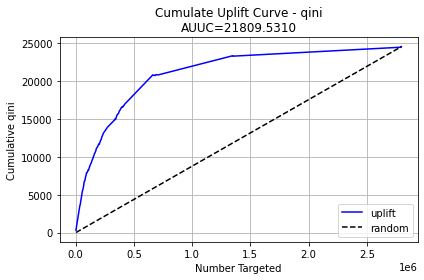

In [20]:
perf_h2o.plot_uplift(metric="qini")

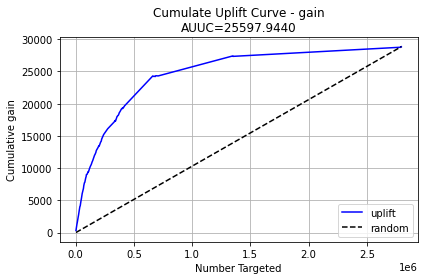

In [21]:
perf_h2o.plot_uplift(metric="gain")

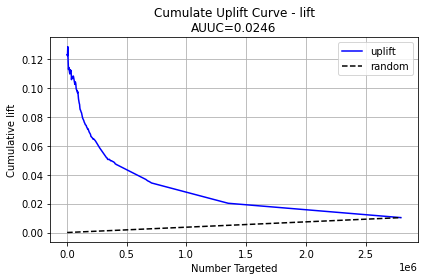

In [22]:
perf_h2o.plot_uplift(metric="lift")

### Qini value and Average Excess Cumulative Uplift (AECU)

Qini value is calculated as the difference between the Qini AUUC and area under the random uplift curve (random AUUC). The random AUUC is computed as diagonal from zero to overall gain uplift. 

The Qini value can be generalized for all AUUC metric types. So AECU for Qini metric is the same as Qini value, but the AECU can be also calculated for Gain and Lift metric type. These values are stored in ``aecu_table``.


In [23]:
perf_h2o.aecu_table()


AECU values table: All types of AECU value


,uplift_type,qini,lift,gain
0,AECU value,5585.905671,0.017788,6511.332738


### Normalized AUUC

To get normalized AUUC, you have to call ``auuc_normalized`` method. The normalized AUUC is calculated from uplift values which are normalized by uplift value from maximal treated number of observations. So if you have for example uplift values [10, 20, 30] the normalized uplift is [1/3, 2/3, 1]. If the maximal value is negative, the normalization factor is the absolute value from this number. The normalized AUUC can be again negative and positive and can be outside of (0, 1) interval. The normalized AUUC for ``auuc_metric="lift"`` is not defined, so the normalized AUUC = AUUC for this case. Also the ``plot_uplift`` with ``metric="lift"`` is the same for ``normalize=False`` and ``normalize=True``.


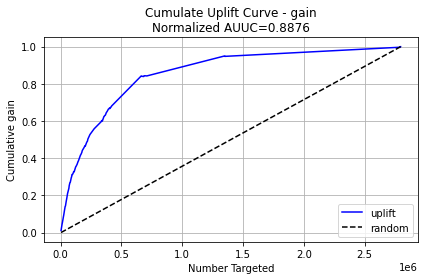

In [24]:
perf_h2o.plot_uplift(metric="gain", normalize=True)

In [25]:
perf_h2o.auuc_normalized()

0.8875808187456685

### Scoring histrory and importance of number of trees

To speed up the calculation of AUUC, the predictions are binned into quantile histograms. To calculate precision AUUC the more bins the better. The more trees usually produce more various predictions and then the algorithm creates histograms with more bins. So the algorithm needs more iterations to get meaningful AUUC results. 
You can see in the scoring history table the number of bins as well as the result AUUC. There is also Qini value parameter, which reflects the number of bins and then is a better pointer of the model improvement. In the scoring history table below you can see the algorithm stabilized after building 6 trees. But it depends on data and model settings on how many trees are necessary.

In [26]:
h2o_uplift_model.scoring_history()

,,timestamp,duration,number_of_trees,training_auuc_nbins,training_auuc,training_auuc_normalized,training_qini_value
0,,2022-07-27 17:29:08,0.080 sec,0.0,0,NaN,NaN,NaN
1,,2022-07-27 17:29:13,4.490 sec,1.0,17,29173.472499,0.829216,43.134923
2,,2022-07-27 17:29:28,19.408 sec,2.0,37,26175.248236,0.743995,543.787973
3,,2022-07-27 17:29:50,41.424 sec,3.0,65,24834.896604,0.705898,1189.586996
4,,2022-07-27 17:30:15,1 min 6.550 sec,4.0,105,24668.993241,0.701182,1993.933129
5,,2022-07-27 17:30:33,1 min 25.226 sec,5.0,151,24978.681660,0.709985,2735.106363
6,,2022-07-27 17:30:56,1 min 47.655 sec,6.0,213,25507.086140,0.725004,3370.884460
7,,2022-07-27 17:31:29,2 min 20.452 sec,7.0,284,26091.307166,0.741610,3906.033948
8,,2022-07-27 17:32:00,2 min 51.737 sec,8.0,357,26636.653904,0.757110,4340.058619
9,,2022-07-27 17:32:24,3 min 15.845 sec,9.0,455,27007.925202,0.767663,4630.005209


## Comparasion Tree-based approach and Generalized Weighed Uplift (LGWUM)

LGWUM (Kane et al., 2014) is one of several methods available for Uplift Modeling, and uses an approach to Uplift Modelling better known as Class Variable Transformation. LGWUM assumes that positive uplift lies in treating treatment-group responders (TR) and control-group non-responders (CN), whilst avoiding treatment-group non-responders (TN) and control-group responders (CR). This is visually shown as:

𝑈𝑝𝑙𝑖𝑓𝑡 𝐿𝐺𝑊𝑈𝑀 = P(TR)/P(T) + P(CN)/P(C) - P(TN)/P(T) - P(CR)/P(C)

source: https://www.kaggle.com/code/hughhuyton/criteo-uplift-modelling/notebook

In [27]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator

h2o_gbm_lgwum = H2OGradientBoostingEstimator(ntrees=ntree,
                                       max_depth=max_depth,
                                       min_rows=30,
                                       nbins=1000,
                                       score_each_iteration=False,
                                       seed=42)

h2o_gbm_lgwum.train(y=response_column_lgwum, x=feature_cols, training_frame=h2o_train_df)
h2o_gbm_lgwum

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1658935440132_24


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,20.0,80.0,4020403.0,15.0,15.0,15.0,1485.0,7251.0,4000.225




ModelMetricsMultinomial: gbm
** Reported on train data. **

MSE: 0.3120011899102808
RMSE: 0.5585706668903057
LogLoss: 0.8287541146830771
Mean Per-Class Error: 0.5801849727146381
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,0,1,2,3,Error,Rate
0,1467565.0,3261.0,134229.0,8390.0,0.090415,"145,880 / 1,613,445"
1,23271.0,14752.0,17688.0,8394.0,0.769878,"49,353 / 64,105"
2,1326320.0,3126.0,257797.0,8611.0,0.838458,"1,338,057 / 1,595,854"
3,25941.0,3018.0,21855.0,30882.0,0.621989,"50,814 / 81,696"
4,2843097.0,24157.0,431569.0,56277.0,0.472148,"1,584,104 / 3,355,100"



Top-4 Hit Ratios: 


,k,hit_ratio
0,1,0.527852
1,2,0.970763
2,3,0.993702
3,4,1.000000



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_classification_error,training_auc,training_pr_auc
0,,2022-07-27 17:39:45,0.053 sec,0.0,0.750000,1.386294,0.541404,NaN,NaN
1,,2022-07-27 17:40:14,29.025 sec,1.0,0.727361,1.299905,0.497912,NaN,NaN
2,,2022-07-27 17:40:33,47.188 sec,2.0,0.707237,1.229294,0.493764,NaN,NaN
3,,2022-07-27 17:40:47,1 min 1.367 sec,3.0,0.689334,1.170673,0.491176,NaN,NaN
4,,2022-07-27 17:41:04,1 min 18.234 sec,4.0,0.673375,1.121350,0.488718,NaN,NaN
5,,2022-07-27 17:41:19,1 min 34.024 sec,5.0,0.659154,1.079499,0.486817,NaN,NaN
6,,2022-07-27 17:41:40,1 min 54.189 sec,6.0,0.646468,1.043701,0.485100,NaN,NaN
7,,2022-07-27 17:41:59,2 min 13.759 sec,7.0,0.635112,1.012794,0.483332,NaN,NaN
8,,2022-07-27 17:42:17,2 min 31.875 sec,8.0,0.624944,0.985980,0.481941,NaN,NaN
9,,2022-07-27 17:42:32,2 min 46.966 sec,9.0,0.615821,0.962585,0.480528,NaN,NaN



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,f8,190623.328125,1.000000,0.447821
1,f2,100747.015625,0.528514,0.236679
2,f0,34038.226562,0.178563,0.079964
3,f9,32690.333984,0.171492,0.076798
4,f6,23321.880859,0.122345,0.054789
5,f3,14699.296875,0.077112,0.034532
6,f10,12903.188477,0.067689,0.030313
7,f7,8790.414062,0.046114,0.020651
8,f4,3861.533691,0.020257,0.009072
9,f5,1799.416138,0.009440,0.004227


In [28]:
uplift_predict_lgwum = h2o_gbm_lgwum.predict(h2o_test_df)

result = uplift_predict_lgwum.as_data_frame()
result.columns = ['predict', 'p_cn', 'p_cr', 'p_tn', 'p_tr']
result['uplift_score'] = result.eval('\
                                p_cn/(p_cn + p_cr) \
                                + p_tr/(p_tn + p_tr) \
                                - p_tn/(p_tn + p_tr) \
                                - p_cr/(p_cn + p_cr)')
result

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,predict,p_cn,p_cr,p_tn,p_tr,uplift_score
0,0,0.463324,0.039048,0.458501,0.039127,0.001798
1,0,0.463402,0.039620,0.457241,0.039737,0.002385
2,0,0.463178,0.039183,0.458256,0.039383,0.002285
3,2,0.360434,0.057130,0.510919,0.071517,-0.028054
4,0,0.463371,0.039052,0.458547,0.039030,0.001423
...,...,...,...,...,...,...
2795914,0,0.268924,0.236619,0.240402,0.254055,0.091514
2795915,2,0.390230,0.080245,0.395348,0.134178,0.165662
2795916,0,0.463304,0.039047,0.458482,0.039167,0.001954
2795917,2,0.445713,0.050914,0.452594,0.050780,-0.003280


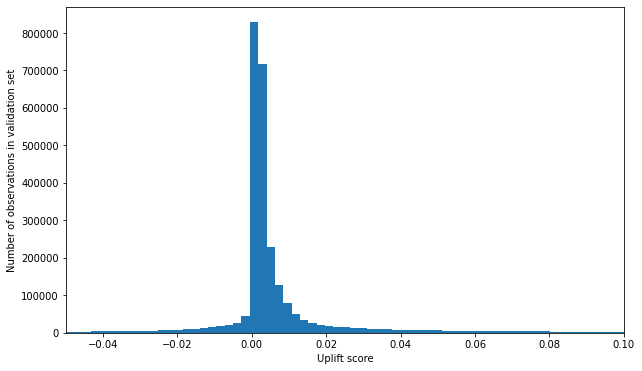

In [29]:
plot_uplift_score(result.uplift_score)

In [30]:
lgwum_predict = h2o.H2OFrame(result['uplift_score'].tolist())
perf_lgwum = h2o.make_metrics(lgwum_predict, h2o_test_df[response_column], treatment=h2o_test_df[treatment_column], auuc_type="gain", auuc_nbins=81)
perf_lgwum

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%

ModelMetricsBinomialUplift: 
** Reported on test data. **

AUUC: 21055.112274915202
AUUC normalized: 0.7300630787164678

AUUC table (number of bins: 80): All types of AUUC value


,uplift_type,qini,lift,gain
0,AUUC value,17937.071150,0.024503,21055.112275
1,AUUC normalized,0.731704,0.024503,0.730063
2,AUUC random value,12417.009135,0.005225,14608.240817



Qini value: 5520.062014219224

AECU values table: All types of AECU value


,uplift_type,qini,lift,gain
0,AECU value,5520.062014,0.019278,6446.871458


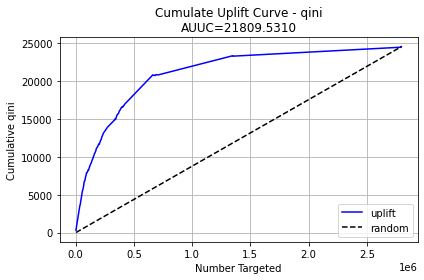

In [31]:
perf_h2o.plot_uplift(metric="qini")

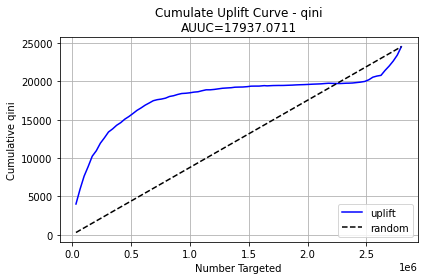

In [32]:
perf_lgwum.plot_uplift(metric="qini")

### Conclusion
From the Qini curves, you can see the Uplift DRF algorithm performs better than the LGWUM algorithm. The main reason is, that the split in Uplift DRF can be more precious thanks to information about both treatment and control groups.

## Uplift trees modeling sources:

- N. J. Radcliffe, and P. D. Surry, “Real-World Uplift Modelling withSignificance-Based Uplift Trees”, Stochastic Solutions White Paper, 2011.

- P. D. Surry, and N. J. Radcliffe, “Quality measures for uplift models”, 2011.

## References

- P. Rzepakowski, and S. Jaroszewicz, “Decision trees for uplift modeling with single and multiple treatments”, 2012.

- Hugh Huyton, “Criteo Uplift Modelling“, 2021, https://www.kaggle.com/code/hughhuyton/criteo-uplift-modelling/notebook.


In [33]:
h2o_train_orig = h2o.import_file("../../bigdata/laptop/criteo-uplift-v2.1.csv")

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


NameError: name 'train_df' is not defined

In [34]:
h2o_train_orig[treatment_column] = h2o_train_orig[treatment_column].asfactor()
h2o_train_orig[response_column] = h2o_train_orig[response_column].asfactor()

In [35]:
ntree = 20
max_depth = 15
metric="Euclidean"

h2o_uplift_model_orig = H2OUpliftRandomForestEstimator(
                    ntrees=ntree,
                    max_depth=max_depth,
                    min_rows=30,
                    nbins=1000,
                    sample_rate=0.80,
                    score_each_iteration=True,
                    treatment_column=treatment_column,
                    uplift_metric=metric,
                    auuc_nbins=1000,
                    auuc_type="gain",
                    seed=42)

h2o_uplift_model_orig.train(y=response_column, x=feature_cols, training_frame=h2o_train_orig)
h2o_uplift_model_orig

upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Model Details
H2OUpliftRandomForestEstimator :  Uplift Distributed Random Forest
Model Key:  UpliftDRF_model_python_1658935440132_26


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,20.0,40.0,118519.0,15.0,15.0,15.0,165.0,299.0,232.6




ModelMetricsBinomialUplift: upliftdrf
** Reported on train data. **

AUUC: 121543.70528131179
AUUC normalized: 0.8406525087980261

AUUC table (number of bins: 979): All types of AUUC value


,uplift_type,qini,lift,gain
0,AUUC value,103627.844465,0.027734,121543.705281
1,AUUC normalized,0.843221,0.027734,0.840653
2,AUUC random value,61520.531851,0.005177,72377.085331



Qini value: 42107.31261443383

AECU values table: All types of AECU value


,uplift_type,qini,lift,gain
0,AECU value,42107.312614,0.022557,49166.61995



Scoring History: 


,,timestamp,duration,number_of_trees,training_auuc_nbins,training_auuc,training_auuc_normalized,training_qini_value
0,,2022-07-27 17:48:20,0.133 sec,0.0,0,NaN,NaN,NaN
1,,2022-07-27 17:48:41,21.093 sec,1.0,17,121218.414882,0.838403,1409.120647
2,,2022-07-27 17:49:52,1 min 32.035 sec,2.0,37,109291.052501,0.755907,5179.507929
3,,2022-07-27 17:51:04,2 min 44.594 sec,3.0,62,104558.905629,0.723178,10258.918235
4,,2022-07-27 17:52:14,3 min 54.545 sec,4.0,104,103080.135740,0.712950,15109.681810
5,,2022-07-27 17:53:27,5 min 7.210 sec,5.0,155,103820.517937,0.718071,19764.545122
6,,2022-07-27 17:54:44,6 min 24.166 sec,6.0,212,105321.543899,0.728453,23537.423744
7,,2022-07-27 17:56:06,7 min 45.837 sec,7.0,283,107626.319029,0.744393,27121.143613
8,,2022-07-27 17:57:30,9 min 10.468 sec,8.0,365,109524.558245,0.757523,29808.691086
9,,2022-07-27 17:59:05,10 min 45.764 sec,9.0,458,111478.522091,0.771037,32180.745399



See the whole table with table.as_data_frame()


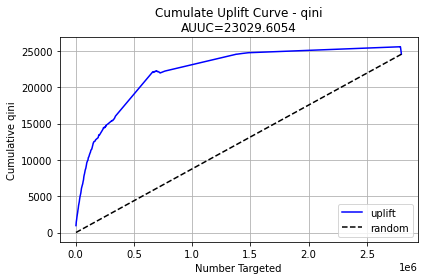

In [36]:
perf_h2o_orig = h2o_uplift_model_orig.model_performance(h2o_test_df)
perf_h2o_orig.plot_uplift(metric="qini")

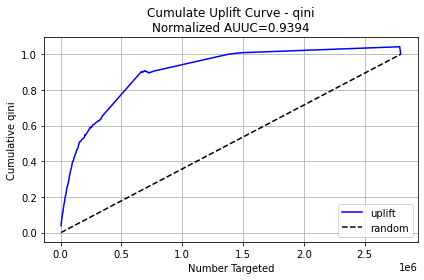

In [37]:
perf_h2o_orig.plot_uplift(metric="qini", normalize=True)

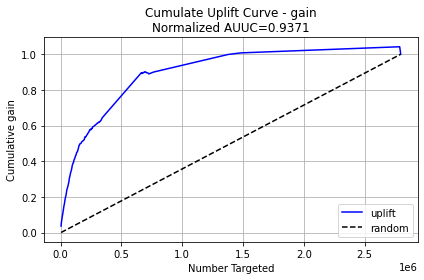

In [38]:
perf_h2o_orig.plot_uplift(metric="gain", normalize=True)

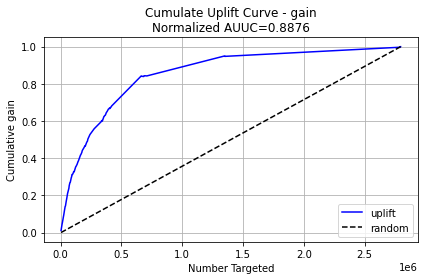

In [39]:
perf_h2o.plot_uplift(metric="gain", normalize=True)

In [ ]:
ntree = 20
max_depth = 15
metric="kl"

h2o_uplift_model_orig_kl = H2OUpliftRandomForestEstimator(
                    ntrees=ntree,
                    max_depth=max_depth,
                    min_rows=30,
                    nbins=1000,
                    sample_rate=0.80,
                    score_each_iteration=True,
                    treatment_column=treatment_column,
                    uplift_metric=metric,
                    auuc_nbins=1000,
                    auuc_type="qini",
                    seed=42)

h2o_uplift_model_orig_kl.train(y=response_column, x=feature_cols, training_frame=h2o_train_orig)
h2o_uplift_model_orig_kl

upliftdrf Model Build progress: |███████████████████████████████████████████████

In [ ]:
ntree = 20
max_depth = 15
metric="chi_squared"

h2o_uplift_model_orig_chi = H2OUpliftRandomForestEstimator(
                    ntrees=ntree,
                    max_depth=max_depth,
                    min_rows=30,
                    nbins=1000,
                    sample_rate=0.80,
                    score_each_iteration=True,
                    treatment_column=treatment_column,
                    uplift_metric=metric,
                    auuc_nbins=1000,
                    auuc_type="qini",
                    seed=42)

h2o_uplift_model_orig_chi.train(y=response_column, x=feature_cols, training_frame=h2o_train_orig)
h2o_uplift_model_orig_chi